In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
import os

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format) # Format floats to 2 decimal places

# Plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

seed = 123

print("Libraries imported.")

Libraries imported.


In [21]:
# Cell 2: Configuration
# --- Paths and Key Column Names ---
ACLED_RAW_PATH = 'data/raw/afgh_may25.csv' # Your ACLED CSV file for Afghanistan
OUTPUT_DIR_EDA = 'data/intermediate/eda_acled_outputs/'
os.makedirs(OUTPUT_DIR_EDA, exist_ok=True)

# Define key column names from your ACLED data (VERIFY THESE MATCH YOUR CSV)
COL_EVENT_ID = 'event_id_cnty'
COL_EVENT_DATE = 'event_date' # Or 'readable_date' if you prefer your converted one
COL_TIMESTAMP = 'timestamp' # For conversion if 'event_date' is not already datetime
COL_YEAR = 'year'
COL_LATITUDE = 'latitude'
COL_LONGITUDE = 'longitude'
COL_COUNTRY = 'country'
COL_ADMIN1 = 'admin1' 
COL_ADMIN2 = 'admin2'
COL_LOCATION = 'location'
COL_EVENT_TYPE = 'event_type'
COL_SUB_EVENT_TYPE = 'sub_event_type'
COL_ACTOR1 = 'actor1'
COL_ACTOR2 = 'actor2' 
COL_INTERACTION = 'interaction'
COL_FATALITIES = 'fatalities'
COL_NOTES = 'notes'
COL_GEO_PRECISION = 'geo_precision'
COL_TIME_PRECISION = 'time_precision'

# --- Date for Regime Shift ---
TAKEOVER_DATE_STR = "2021-08-15" 
try:
    TAKEOVER_DATE = pd.to_datetime(TAKEOVER_DATE_STR)
except ValueError:
    print(f"Error parsing TAKEOVER_DATE_STR: {TAKEOVER_DATE_STR}. Using a default.")
    TAKEOVER_DATE = pd.to_datetime("2021-08-15")

# --- Target variable for later ML ---
TARGET_LOG_FATALITIES = 'log_fatalities'

# --- Map Configuration (Ensure these are defined) ---
AFGHANISTAN_CENTER_LAT = 33.93911 # Approximate center of Afghanistan
AFGHANISTAN_CENTER_LON = 67.709953
DEFAULT_MAP_ZOOM = 6 # Initial zoom level for Folium maps

print("Configuration set.")

Configuration set.


In [22]:
df = pd.DataFrame() 
try:
    df_full_acled = pd.read_csv(ACLED_RAW_PATH, low_memory=False)
    print(f"Successfully loaded full ACLED data from: {ACLED_RAW_PATH}")
    
    if COL_COUNTRY in df_full_acled.columns:
        df = df_full_acled[df_full_acled[COL_COUNTRY] == "Afghanistan"].copy()
        print(f"Filtered for Afghanistan. Shape: {df.shape}")
        if df.empty:
            print("WARNING: No data found for Afghanistan in the loaded file.")
    else:
        print(f"Warning: '{COL_COUNTRY}' column not found. Assuming data is already for Afghanistan.")
        df = df_full_acled.copy()
    
    print(f"Initial Afghanistan data shape: {df.shape}")

except FileNotFoundError:
    print(f"ERROR: Raw ACLED data file not found at '{ACLED_RAW_PATH}'. EDA will be limited.")
    # Create a minimal dummy for script flow, actual EDA needs real data
    df = pd.DataFrame({
        COL_EVENT_DATE: pd.to_datetime(['2020-01-01', '2021-09-01', '2022-03-15']),
        COL_LATITUDE: [34.5, 33.0, 36.0], COL_LONGITUDE: [69.2, 65.0, 67.0],
        COL_ADMIN1: ['Kabul', 'Helmand', 'Balkh'], COL_FATALITIES: [2, 0, 5],
        COL_EVENT_TYPE: ['Battles', 'Violence against civilians', 'Explosions/Remote violence'],
        COL_ACTOR1: ['Taliban', 'Military Forces of Afghanistan (2021-)', 'Islamic State (Khorasan)']
    })
    print(f"Using minimal DUMMY data. Shape: {df.shape}")

if df.empty:
    print("DataFrame is empty. Cannot proceed with EDA.")
else:
    print("\nFirst 5 rows of Afghanistan data:")
    # display(df.head())
    print("\nDataFrame Info:")
    df.info()

Successfully loaded full ACLED data from: data/raw/afgh_may25.csv
Filtered for Afghanistan. Shape: (7940, 32)
Initial Afghanistan data shape: (7940, 32)

First 5 rows of Afghanistan data:

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7940 entries, 0 to 7939
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event_id_cnty       7940 non-null   object 
 1   event_date          7940 non-null   object 
 2   year                7940 non-null   int64  
 3   time_precision      7940 non-null   int64  
 4   disorder_type       7940 non-null   object 
 5   event_type          7940 non-null   object 
 6   sub_event_type      7940 non-null   object 
 7   actor1              7940 non-null   object 
 8   assoc_actor_1       482 non-null    object 
 9   inter1              7940 non-null   object 
 10  actor2              7940 non-null   object 
 11  assoc_actor_2       3754 non-null   object 
 1

In [23]:
if not df.empty:
    print("\n--- Initial Cleaning & Basic Feature Creation ---")

    # 1. Date Conversion
    if COL_EVENT_DATE not in df.columns and COL_TIMESTAMP in df.columns: # If event_date is missing but timestamp exists
        print(f"Converting '{COL_TIMESTAMP}' to '{COL_EVENT_DATE}'")
        df[COL_EVENT_DATE] = pd.to_datetime(df[COL_TIMESTAMP], unit='s', errors='coerce')
    elif COL_EVENT_DATE in df.columns:
        df[COL_EVENT_DATE] = pd.to_datetime(df[COL_EVENT_DATE], errors='coerce')
    else:
        print(f"ERROR: Neither '{COL_EVENT_DATE}' nor '{COL_TIMESTAMP}' found. Cannot process dates.")
        # df = pd.DataFrame() # Stop further processing if no date

    if COL_EVENT_DATE in df.columns:
        if df[COL_EVENT_DATE].isna().any():
            print(f"  {df[COL_EVENT_DATE].isna().sum()} events have invalid/missing dates after conversion.")
        df.dropna(subset=[COL_EVENT_DATE], inplace=True)
        print(f"  '{COL_EVENT_DATE}' processed. Shape after dropping date NaNs: {df.shape}")

    # 2. Numeric Conversions & Essential NaNs
    cols_to_numeric = [COL_LATITUDE, COL_LONGITUDE, COL_FATALITIES, COL_GEO_PRECISION, COL_TIME_PRECISION]
    for col in cols_to_numeric:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if col == COL_FATALITIES:
                df[col] = df[col].fillna(0).astype(int)
        elif col == COL_FATALITIES: # Ensure fatalities column exists
            df[COL_FATALITIES] = 0
            print(f"Warning: '{COL_FATALITIES}' column not found. Created with zeros.")


    essential_cols_for_eda = [COL_EVENT_DATE, COL_LATITUDE, COL_LONGITUDE, COL_ADMIN1, COL_FATALITIES]
    essential_cols_present = [col for col in essential_cols_for_eda if col in df.columns]
    
    rows_before_essential_dropna = len(df)
    df.dropna(subset=essential_cols_present, inplace=True)
    if rows_before_essential_dropna > len(df):
        print(f"Dropped {rows_before_essential_dropna - len(df)} rows due to NaNs in essential EDA columns: {essential_cols_present}.")
    print(f"Shape after ensuring essential EDA columns: {df.shape}")

    if not df.empty:
        # 3. Create log_fatalities
        df[TARGET_LOG_FATALITIES] = np.log1p(df[COL_FATALITIES])
        print(f"Target '{TARGET_LOG_FATALITIES}' created.")

        # 4. Create basic time features
        df['year'] = df[COL_EVENT_DATE].dt.year
        df['month'] = df[COL_EVENT_DATE].dt.month
        df['year_month'] = df[COL_EVENT_DATE].dt.to_period('M')
        df['dayofweek'] = df[COL_EVENT_DATE].dt.day_name() # String name
        print("Basic time features (year, month, year_month, dayofweek) created.")

        # 5. Create is_post_takeover flag
        df['is_post_takeover'] = (df[COL_EVENT_DATE] >= TAKEOVER_DATE).astype(int)
        print(f"'is_post_takeover' flag created (1 if date >= {TAKEOVER_DATE_STR}).")
        # print(df['is_post_takeover'].value_counts(normalize=True))
        
        # Sort data for time series plots
        df.sort_values(COL_EVENT_DATE, inplace=True)
        df.reset_index(drop=True, inplace=True)

    else:
        print("DataFrame became empty after initial cleaning. Cannot proceed with EDA.")
else:
    print("DataFrame initially empty. EDA skipped.")


--- Initial Cleaning & Basic Feature Creation ---
  'event_date' processed. Shape after dropping date NaNs: (7940, 32)
Shape after ensuring essential EDA columns: (7940, 32)
Target 'log_fatalities' created.
Basic time features (year, month, year_month, dayofweek) created.
'is_post_takeover' flag created (1 if date >= 2021-08-15).



--- Univariate Analysis: Fatalities ---


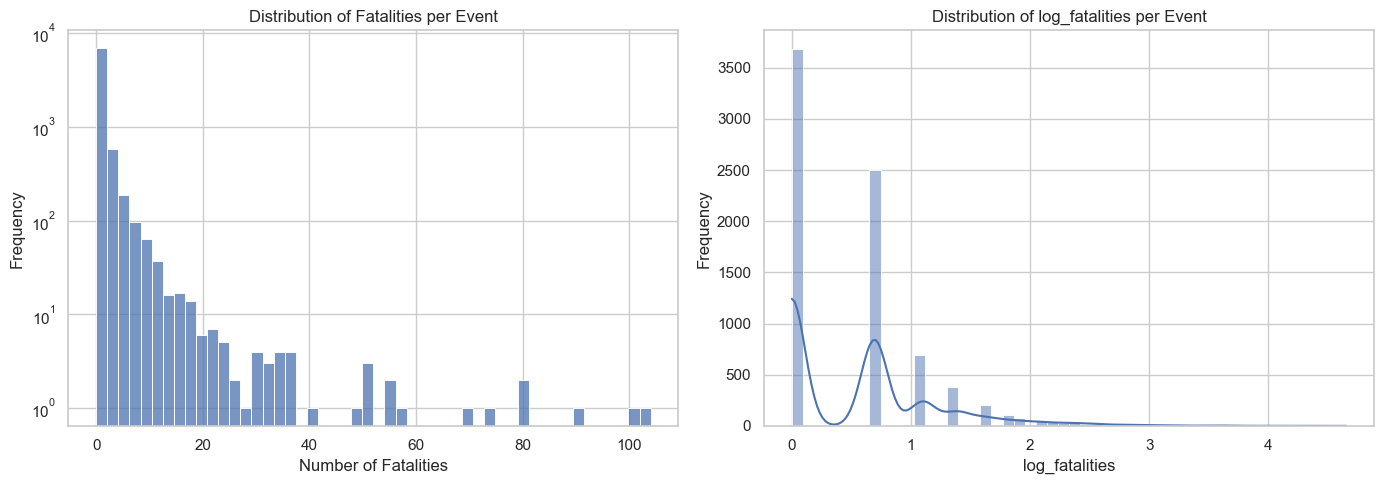

In [24]:
if not df.empty:
    print("\n--- Univariate Analysis: Fatalities ---")
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[COL_FATALITIES], bins=50, kde=False)
    plt.title('Distribution of Fatalities per Event')
    plt.xlabel('Number of Fatalities')
    plt.ylabel('Frequency')
    plt.yscale('log') # Often needed due to skew

    plt.subplot(1, 2, 2)
    sns.histplot(df[TARGET_LOG_FATALITIES], bins=50, kde=True)
    plt.title(f'Distribution of {TARGET_LOG_FATALITIES} per Event')
    plt.xlabel(f'{TARGET_LOG_FATALITIES}')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    # plt.savefig(os.path.join(OUTPUT_DIR_EDA, 'fatalities_distribution.png'))
    # plt.show()
    # plt.close()
    
    # print(df[[COL_FATALITIES, TARGET_LOG_FATALITIES]].describe())
else:
    print("DataFrame empty. Skipping fatalities EDA.")


--- Univariate Analysis: Events Over Time ---


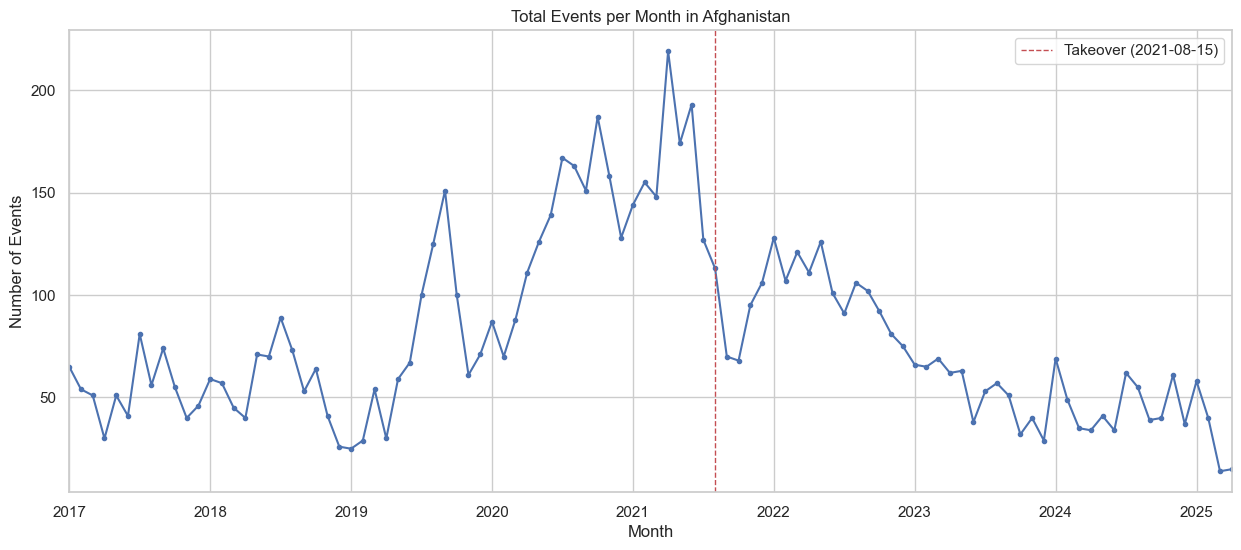

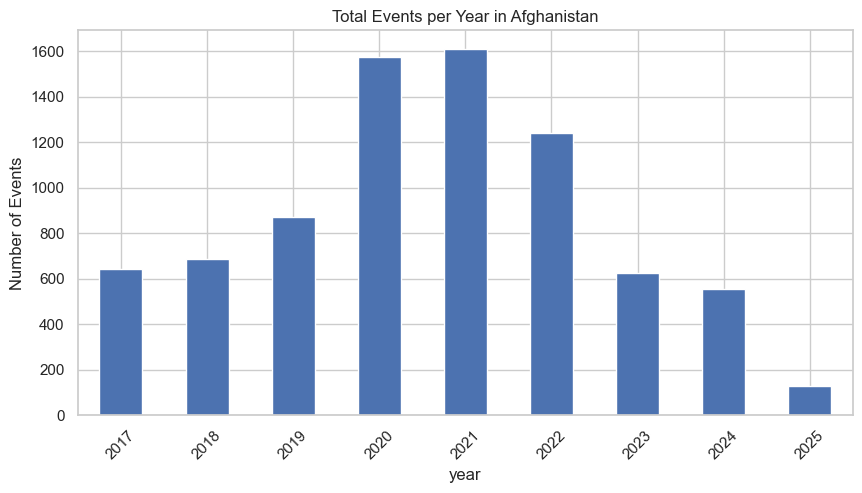

In [25]:
if not df.empty and 'year_month' in df.columns:
    print("\n--- Univariate Analysis: Events Over Time ---")
    monthly_event_counts = df.groupby('year_month').size()
    # Convert PeriodIndex to DateTimeIndex for nicer plotting if needed, or plot directly
    if isinstance(monthly_event_counts.index, pd.PeriodIndex):
        monthly_event_counts.index = monthly_event_counts.index.to_timestamp()

    plt.figure(figsize=(15, 6))
    monthly_event_counts.plot(kind='line', marker='.')
    plt.title('Total Events per Month in Afghanistan')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.axvline(TAKEOVER_DATE, color='r', linestyle='--', lw=1, label=f'Takeover ({TAKEOVER_DATE_STR})')
    plt.legend()
    plt.grid(True)
    # plt.savefig(os.path.join(OUTPUT_DIR_EDA, 'monthly_event_counts.png'))
    # plt.show()
    # plt.close()

    # Yearly counts
    plt.figure(figsize=(10, 5))
    df.groupby('year').size().plot(kind='bar')
    plt.title('Total Events per Year in Afghanistan')
    plt.ylabel('Number of Events')
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(OUTPUT_DIR_EDA, 'yearly_event_counts.png'))
    # plt.show()
    # plt.close()
else:
    print("DataFrame empty or 'year_month' missing. Skipping event time distribution EDA.")


--- Univariate Analysis: Categorical Variables ---


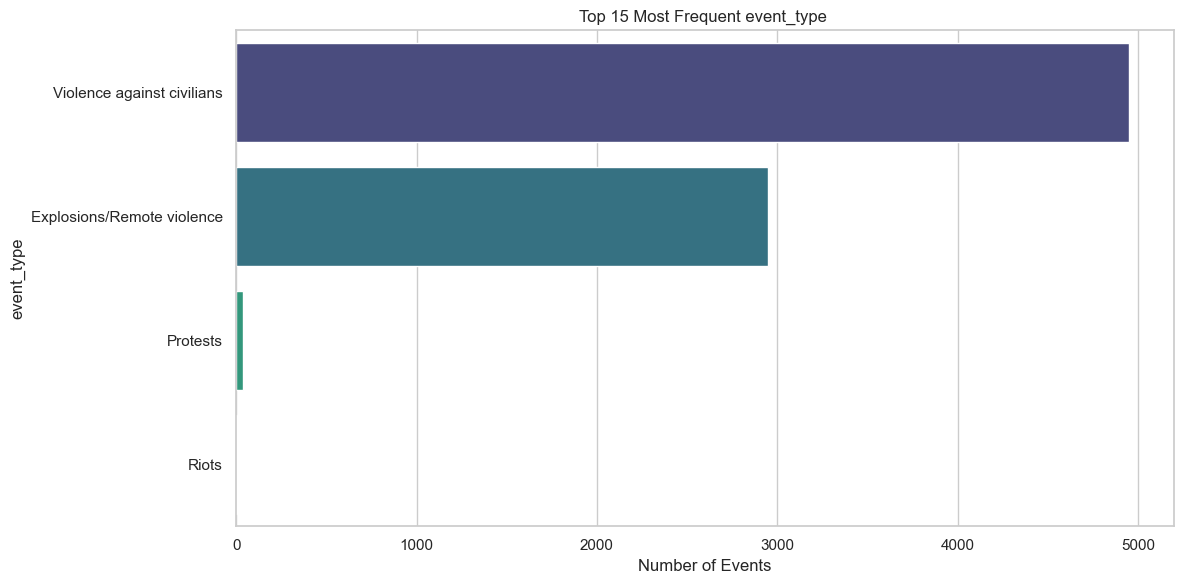

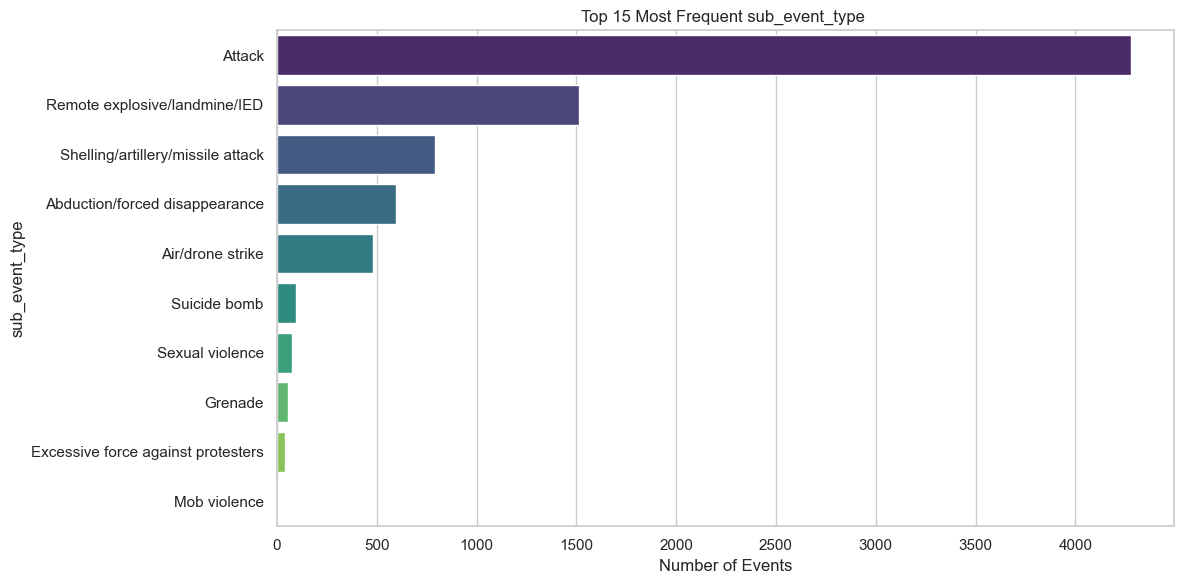

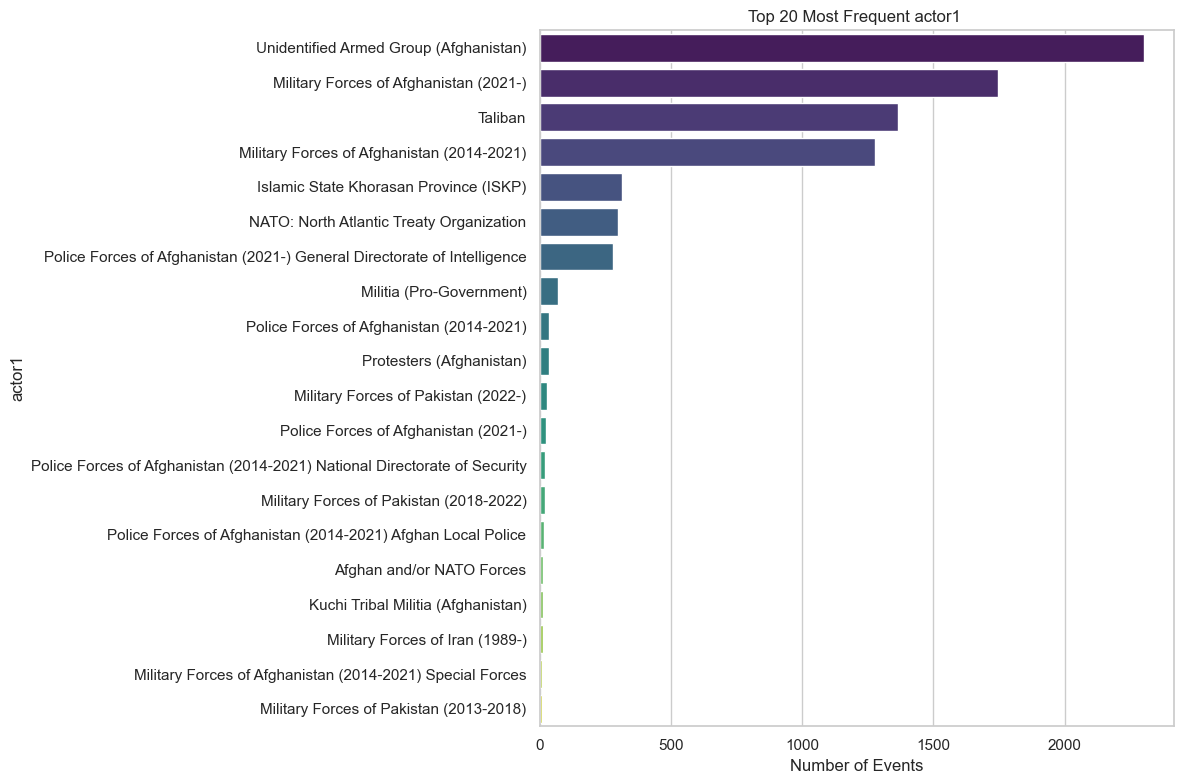

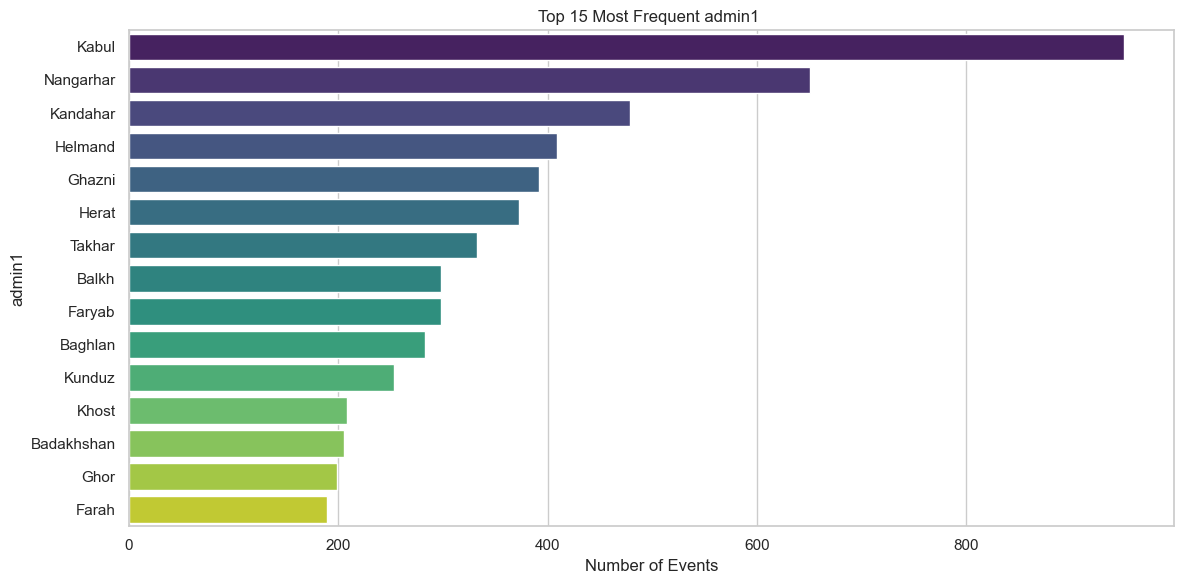

In [26]:
if not df.empty:
    print("\n--- Univariate Analysis: Categorical Variables ---")
    
    def plot_top_n_categories(dataframe, column, top_n=15, title_suffix=""):
        if column not in dataframe.columns:
            print(f"Column '{column}' not found in DataFrame. Skipping plot.")
            return
        plt.figure(figsize=(12, max(6, top_n*0.4))) # Adjust height
        counts = dataframe[column].value_counts().nlargest(top_n)
        sns.barplot(x=counts.values, y=counts.index, palette="viridis", hue=counts.index, legend=False) # Added hue for color
        plt.title(f'Top {top_n} Most Frequent {column} {title_suffix}')
        plt.xlabel('Number of Events')
        plt.ylabel(column)
        plt.tight_layout()
        # plt.savefig(os.path.join(OUTPUT_DIR_EDA, f'top_{top_n}_{column.lower()}.png'))
        # plt.show()
        # plt.close()

    plot_top_n_categories(df, COL_EVENT_TYPE)
    plot_top_n_categories(df, COL_SUB_EVENT_TYPE)
    plot_top_n_categories(df, COL_ACTOR1, top_n=20) # Show more for actors
    plot_top_n_categories(df, COL_ADMIN1, top_n=15)
else:
    print("DataFrame empty. Skipping categorical EDA.")


--- Bivariate Analysis: Log Fatalities vs. Categories ---

Comparing Log Fatalities Pre vs. Post Takeover:


/var/folders/vd/mn3_24hn4hn_nn8wm4lzbd980000gn/T/ipykernel_42120/3157285243.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_post_takeover', y=TARGET_LOG_FATALITIES, palette="pastel")


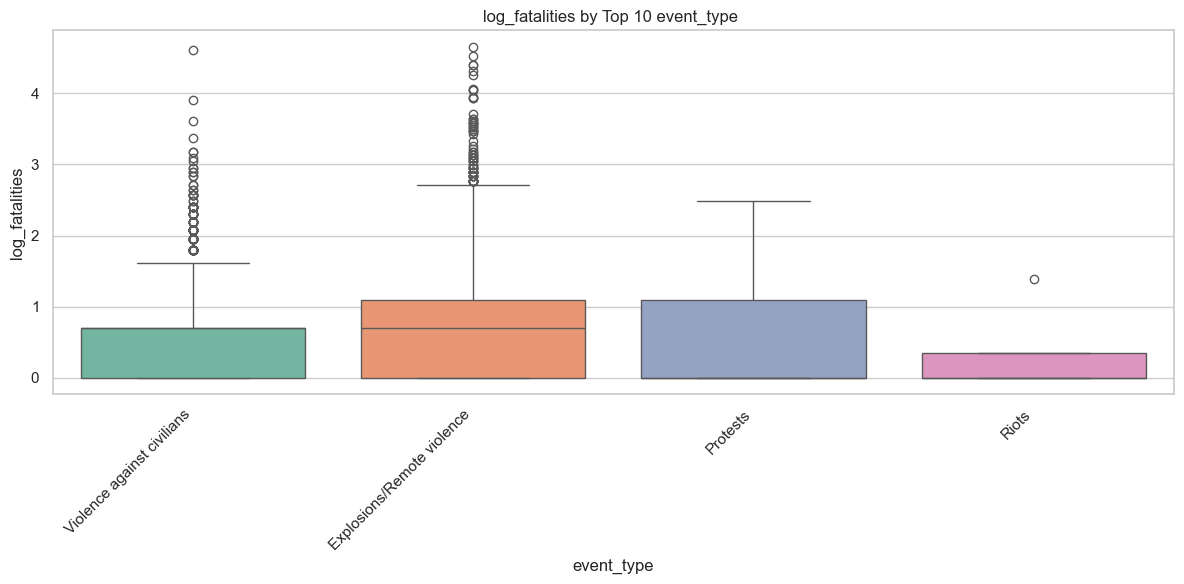

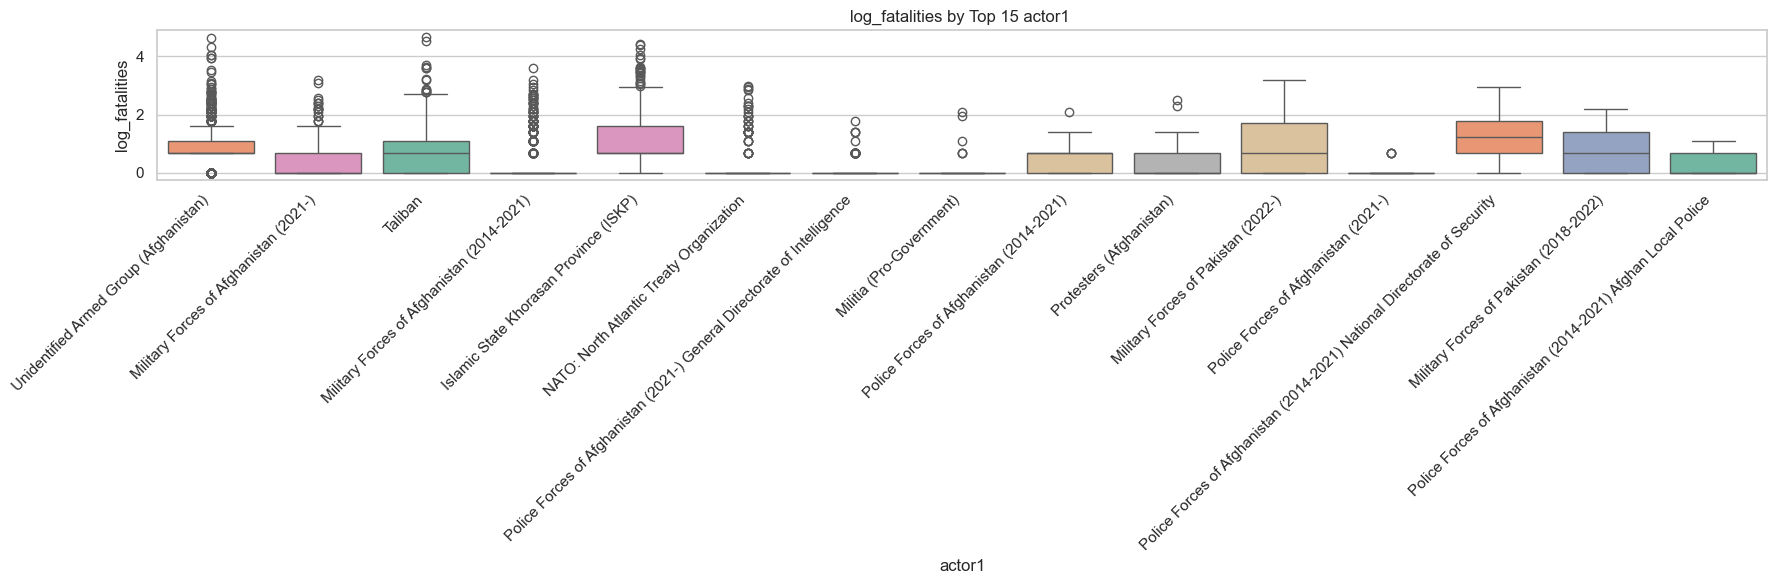

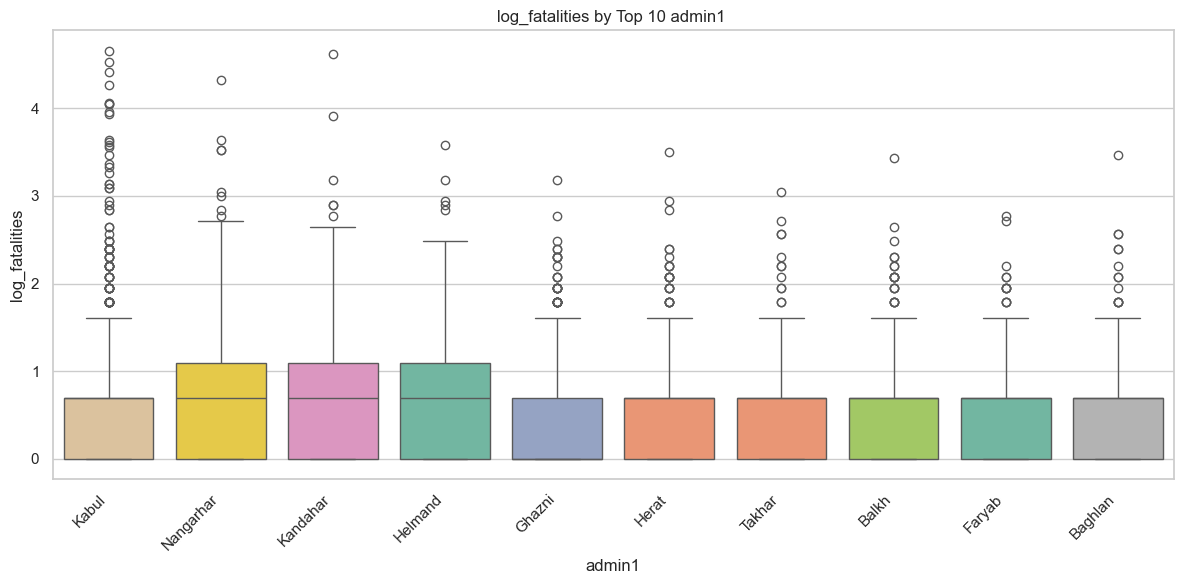

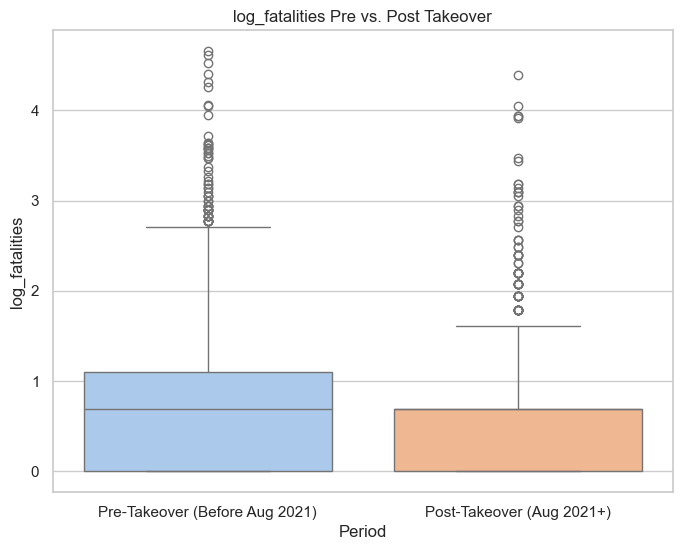

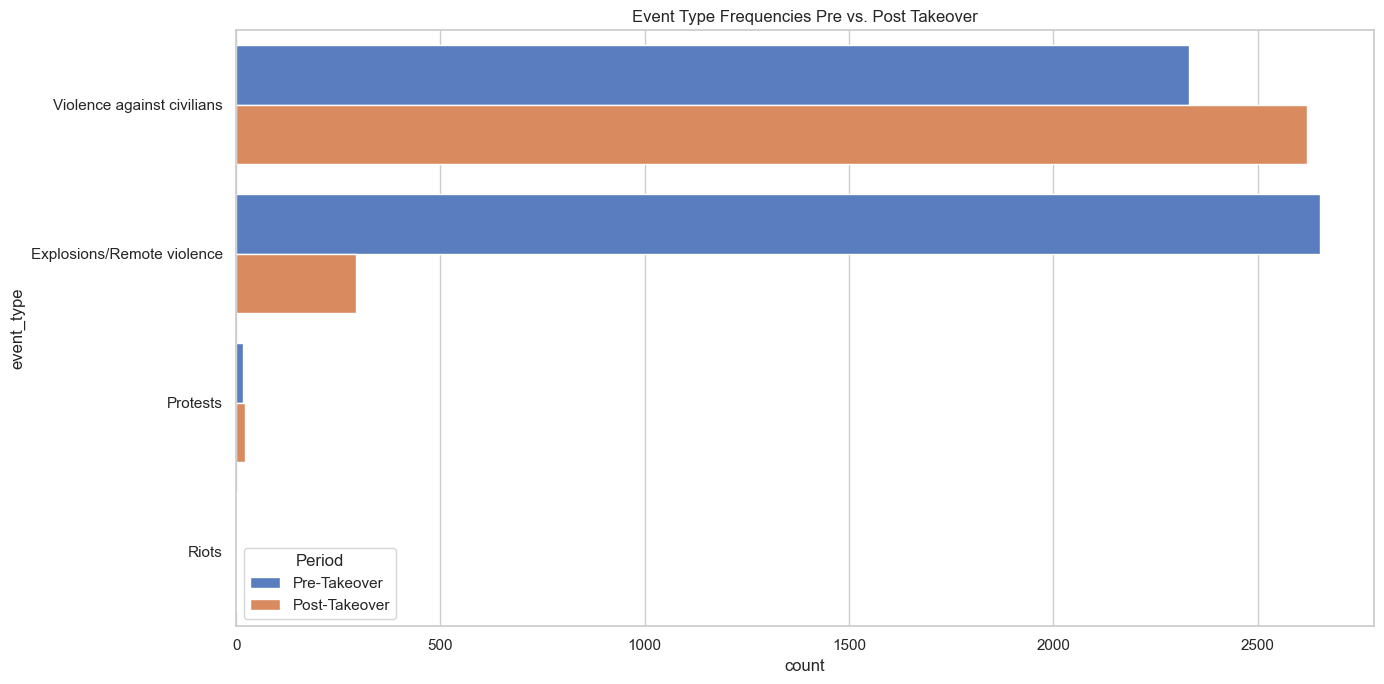

In [27]:
if not df.empty:
    print("\n--- Bivariate Analysis: Log Fatalities vs. Categories ---")

    def plot_log_fatalities_by_category(dataframe, category_col, top_n=10, title_suffix=""):
        if category_col not in dataframe.columns or TARGET_LOG_FATALITIES not in dataframe.columns:
            print(f"Required columns ('{category_col}' or '{TARGET_LOG_FATALITIES}') not found. Skipping plot.")
            return
        
        # Get top N categories by event count
        top_categories = dataframe[category_col].value_counts().nlargest(top_n).index
        df_top_cat = dataframe[dataframe[category_col].isin(top_categories)]

        plt.figure(figsize=(max(12, top_n*1.2), 6)) # Adjust width
        sns.boxplot(data=df_top_cat, x=category_col, y=TARGET_LOG_FATALITIES, 
                    order=top_categories, palette="Set2", hue=category_col, legend=False) # Added hue
        plt.title(f'{TARGET_LOG_FATALITIES} by Top {top_n} {category_col} {title_suffix}')
        plt.xlabel(category_col)
        plt.ylabel(TARGET_LOG_FATALITIES)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # plt.savefig(os.path.join(OUTPUT_DIR_EDA, f'logfat_by_{category_col.lower()}.png'))
        # plt.show()
        # plt.close()

    plot_log_fatalities_by_category(df, COL_EVENT_TYPE)
    plot_log_fatalities_by_category(df, COL_ACTOR1, top_n=15)
    plot_log_fatalities_by_category(df, COL_ADMIN1)

    # --- Pre vs. Post Takeover comparison for key variables ---
    if 'is_post_takeover' in df.columns:
        print("\nComparing Log Fatalities Pre vs. Post Takeover:")
        plt.figure(figsize=(8,6))
        sns.boxplot(data=df, x='is_post_takeover', y=TARGET_LOG_FATALITIES, palette="pastel")
        plt.title(f'{TARGET_LOG_FATALITIES} Pre vs. Post Takeover')
        plt.xticks([0, 1], ['Pre-Takeover (Before Aug 2021)', 'Post-Takeover (Aug 2021+)'])
        plt.xlabel("Period")
        # plt.savefig(os.path.join(OUTPUT_DIR_EDA, 'logfat_pre_post_takeover.png'))
        # plt.show()
        # plt.close()

        # Compare event types pre/post
        plt.figure(figsize=(14,7))
        sns.countplot(data=df, y=COL_EVENT_TYPE, hue='is_post_takeover', 
                      order=df[COL_EVENT_TYPE].value_counts().index[:10], palette="muted") # Top 10 event types
        plt.title('Event Type Frequencies Pre vs. Post Takeover')
        plt.legend(title="Period", labels=['Pre-Takeover', 'Post-Takeover'])
        plt.tight_layout()
        # plt.savefig(os.path.join(OUTPUT_DIR_EDA, 'eventtype_pre_post_takeover.png'))
        # plt.show()
        # plt.close()
else:
    print("DataFrame empty. Skipping bivariate EDA.")

In [30]:
# Cell 9: Spatial EDA - Maps

if not df.empty and COL_LATITUDE in df.columns and COL_LONGITUDE in df.columns:
    print("\n--- Spatial EDA: Maps ---")
    
    # Create a sample for mapping if df is too large, to keep maps responsive
    df_map_sample = df.sample(n=min(5000, len(df)), random_state=42) if len(df) > 5000 else df.copy() # Use your seed if defined, e.g. seed from Cell 1
    print(f"Using {len(df_map_sample)} events for map visualizations.")

    # 1. Heatmap of All Event Density
    # Ensure map defaults are available (should be defined in Cell 2)
    map_all_events_density = folium.Map(location=[AFGHANISTAN_CENTER_LAT, AFGHANISTAN_CENTER_LON], zoom_start=DEFAULT_MAP_ZOOM)
    heat_data = [[row[COL_LATITUDE], row[COL_LONGITUDE]] for index, row in df_map_sample.iterrows() if pd.notna(row[COL_LATITUDE]) and pd.notna(row[COL_LONGITUDE])]
    if heat_data:
        HeatMap(heat_data, radius=15).add_to(map_all_events_density)
        print("Overall event density heatmap created.")
        # display(map_all_events_density)
        # map_all_events_density.save(os.path.join(OUTPUT_DIR_EDA, 'heatmap_all_events_density.html'))
    else:
        print("No valid data for overall event density heatmap.")

    # 2. Heatmap of Average Log Fatalities per Area (more complex, requires gridding first)
    # For simplicity, let's plot points colored by log_fatalities
    
    map_fatalities = folium.Map(location=[AFGHANISTAN_CENTER_LAT, AFGHANISTAN_CENTER_LON], zoom_start=DEFAULT_MAP_ZOOM)
    
    def get_color_by_fatality(log_fat):
        if pd.isna(log_fat): return 'gray'
        if log_fat == 0: return 'green'      # No fatalities
        elif log_fat <= np.log1p(5): return 'orange' # Low to Mid
        else: return 'red'                 # High

    # events_fg = folium.FeatureGroup(name="Events by Log Fatalities")
    # for idx, row in df_map_sample.iterrows():
    #     if pd.notna(row[COL_LATITUDE]) and pd.notna(row[COL_LONGITUDE]):
    #         folium.CircleMarker(
    #             location=[row[COL_LATITUDE], row[COL_LONGITUDE]],
    #             radius=3,
    #             color=get_color_by_fatality(row[TARGET_LOG_FATALITIES]),
    #             fill=True,
    #             fill_color=get_color_by_fatality(row[TARGET_LOG_FATALITIES]),
    #             fill_opacity=0.7,
    #             popup=f"LogFat: {row[TARGET_LOG_FATALITIES]:.2f}<br>Date: {row[COL_EVENT_DATE].strftime('%Y-%m-%d') if pd.notna(row[COL_EVENT_DATE]) else 'N/A'}"
    #         ).add_to(events_fg)
    # events_fg.add_to(map_fatalities)
    # folium.LayerControl().add_to(map_fatalities)
    # print("Map with events colored by log_fatalities created (potentially slow).")
    # display(map_fatalities)
    # map_fatalities.save(os.path.join(OUTPUT_DIR_EDA, 'map_events_by_log_fatalities.html'))

    # 3. Pre vs. Post Takeover Spatial Density Comparison
    if 'is_post_takeover' in df.columns:
        print("Creating Pre vs. Post Takeover density maps...")
        df_pre_takeover_map = df_map_sample[df_map_sample['is_post_takeover'] == 0]
        df_post_takeover_map = df_map_sample[df_map_sample['is_post_takeover'] == 1]

        map_pre = folium.Map(location=[AFGHANISTAN_CENTER_LAT, AFGHANISTAN_CENTER_LON], zoom_start=DEFAULT_MAP_ZOOM, tiles="CartoDB positron")
        folium.TileLayer('openstreetmap').add_to(map_pre)
        heat_data_pre = [[r[COL_LATITUDE], r[COL_LONGITUDE]] for i, r in df_pre_takeover_map.iterrows() if pd.notna(r[COL_LATITUDE]) and pd.notna(r[COL_LONGITUDE])]
        if heat_data_pre: HeatMap(heat_data_pre, name="Pre-Takeover Density").add_to(map_pre)
        folium.LayerControl().add_to(map_pre)
        map_pre.save(os.path.join(OUTPUT_DIR_EDA, 'heatmap_density_pre_takeover.html'))
        print("  Pre-takeover density map generated.")
        display(map_pre)


        map_post = folium.Map(location=[AFGHANISTAN_CENTER_LAT, AFGHANISTAN_CENTER_LON], zoom_start=DEFAULT_MAP_ZOOM, tiles="CartoDB positron")
        folium.TileLayer('openstreetmap').add_to(map_post)
        heat_data_post = [[r[COL_LATITUDE], r[COL_LONGITUDE]] for i, r in df_post_takeover_map.iterrows() if pd.notna(r[COL_LATITUDE]) and pd.notna(r[COL_LONGITUDE])]
        if heat_data_post: HeatMap(heat_data_post, name="Post-Takeover Density").add_to(map_post)
        folium.LayerControl().add_to(map_post)
        map_post.save(os.path.join(OUTPUT_DIR_EDA, 'heatmap_density_post_takeover.html'))
        print("  Post-takeover density map generated.")
        display(map_post)
else:
    print("DataFrame empty or coordinate columns missing. Skipping map EDA.")


--- Spatial EDA: Maps ---
Using 5000 events for map visualizations.
Overall event density heatmap created.
Creating Pre vs. Post Takeover density maps...
  Pre-takeover density map generated.


  Post-takeover density map generated.
